##Library and PyPI

In [1]:
# Install
!pip install geopandas
!pip install country_converter
!pip install geoplot
# !pip install plotly>=4.7.1
# !wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
# !chmod +x /usr/local/bin/orca
# !apt-get install xvfb libgtk2.0-0 libgconf-2-4
!pip install tueplots

     |████████████████████████████████| 1.0 MB 4.1 MB/s 
     |████████████████████████████████| 15.4 MB 47.5 MB/s 
     |████████████████████████████████| 6.3 MB 45.4 MB/s 
     |████████████████████████████████| 50 kB 2.9 MB/s 
  Created wheel for country-converter: filename=country_converter-0.7.4-py3-none-any.whl size=53543 sha256=7b642c2792e94be24321b4bdd41d54cca9cdca7b1f3842aa65a0aae7da955c56
  Stored in directory: /root/.cache/pip/wheels/69/cf/84/9ebca78737327440a0bb5faa6d0380e9017730534cf0dbcb8c
Successfully built country-converter
     |████████████████████████████████| 10.8 MB 5.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 30.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 33.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |█████

In [2]:
# library
import numpy as np
import pandas as pd
import geopandas as geo
import geoplot as gplt
import matplotlib.pyplot as plt
import country_converter as coco
import seaborn as sns
from tueplots import bundles
plt.rcParams.update(bundles.neurips2021(usetex=False)) # this work not good for geopandas


##Data Preprocessing

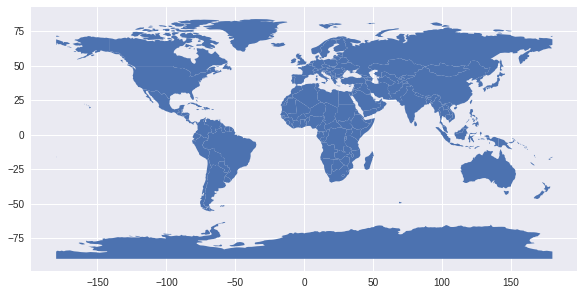

In [30]:
# load data into the dataset
dataset = pd.read_csv("https://salaries.freshremote.work/download/salaries.csv")

#see what world dataset are available
geo.datasets.available

# get information from world and city
world = geo.read_file(geo.datasets.get_path('naturalearth_lowres'))
# cities = geo.read_file(geo.datasets.get_path('naturalearth_cities'))
# nybb = geo.read_file(geo.datasets.get_path('nybb'))
world.plot()

In [31]:
# dataset has iso in type 2 and world in type 3
# convert them to the ISO3
converter = coco.CountryConverter()
iso3 = converter.convert(names = dataset.company_location, src = 'ISO2', to = 'ISO3')
dataset = dataset.replace(dataset.company_location.to_list(), iso3)

In [32]:
# County ISOs
dataset_isos = dataset.company_location.unique()
world_isos = world.iso_a3.unique()

# Find ISOs only in one of the two county ISO sets
unmatched_isos = np.setxor1d(dataset_isos, world_isos) #-----> difference
print(f"Countries in the company location but not in the world: \n{dataset[dataset.company_location.isin(unmatched_isos)].company_location.unique()}")
print(f"Countries in the world but not in the company location: \n{world[world.iso_a3.isin(unmatched_isos)].iso_a3.unique()}")


Countries in the company location but not in the world: 
['NOR' 'FRA' 'SGP' 'UMI' 'MLT' 'ASM']
Countries in the world but not in the company location: 
['FJI' 'TZA' 'ESH' 'UZB' 'PNG' 'COD' 'SOM' 'SDN' 'TCD' 'HTI' 'DOM' 'BHS'
 'FLK' '-99' 'GRL' 'ATF' 'TLS' 'LSO' 'URY' 'BOL' 'NIC' 'HND' 'GTM' 'BLZ'
 'VEN' 'GUY' 'SUR' 'ECU' 'PRI' 'JAM' 'CUB' 'ZWE' 'BWA' 'NAM' 'SEN' 'MLI'
 'MRT' 'BEN' 'NER' 'CMR' 'TGO' 'GHA' 'CIV' 'GIN' 'GNB' 'LBR' 'SLE' 'BFA'
 'CAF' 'COG' 'GAB' 'GNQ' 'ZMB' 'MWI' 'MOZ' 'SWZ' 'AGO' 'BDI' 'LBN' 'MDG'
 'PSE' 'GMB' 'JOR' 'QAT' 'OMN' 'VUT' 'KHM' 'LAO' 'MMR' 'VNM' 'PRK' 'MNG'
 'BGD' 'BTN' 'NPL' 'TJK' 'KGZ' 'TKM' 'SYR' 'BLR' 'MDA' 'ALB' 'NCL' 'SLB'
 'CHN' 'ISL' 'AZE' 'GEO' 'ERI' 'PRY' 'YEM' 'SAU' 'ATA' 'CYP' 'MAR' 'LBY'
 'ETH' 'DJI' 'UGA' 'RWA' 'MNE' 'TTO' 'SSD']


In [33]:
world.loc[21,'iso_a3']

'-99'

In [34]:
#Nor and Fra only have code -99
world.loc[21,'iso_a3'] = 'NOR' 
world.loc[43,'iso_a3'] = 'FRA' 

# delete 'SGP' and 'MLT' rows
dataset = dataset.drop(dataset[dataset.company_location == 'SGP'].index)
dataset = dataset.drop(dataset[dataset.company_location == 'MLT'].index)

# change iso code 'UMI', 'ASM' to 'USA'
dataset = dataset.replace(['UMI', 'ASM'],'USA')

In [35]:
dataset.head(5)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2021,SWE,FT,Security Specialist,211000,USD,211000,USA,100,USA,L
1,2022,SWE,FT,DevOps Security Engineer,120000,CAD,95213,CAN,100,CAN,L
2,2022,SWE,FT,Information Security Manager,174000,BRL,31203,BRA,100,BRA,L
3,2022,EX,FT,Head of Security,220000,USD,220000,USA,100,USA,L
4,2022,SWE,FT,Cybersecurity Analyst,180000,BRL,32279,BRA,100,BRA,L


##Choropleth map

In [10]:
# add counter to the dataset to count the jobs
# because we are missing lots of data:
# we consider the same job with different experience level as different jobs
# we consider the same job from different company size as different jobs
# we consider the same job with different employment type as different jobs
length = len(dataset.remote_ratio.to_list())
counter = np.ones(length)
dataset['counter'] = counter

# we only consider the data in 2020 
dataset = dataset[dataset.work_year == '2020']

### Remote working vs Location 2020


In [11]:
# sum the jobs number regarding to different remote ratio [0, 50, 100]
# here we do not consider the salary, counter
dataset_remote = (
    dataset.groupby(["company_location","remote_ratio"])
    .sum()
    .reset_index()
)


In [13]:
# Merge into single data frame
dataset_remote_geo = dataset_remote.merge(
    world, how="inner", left_on="company_location", right_on="iso_a3"
)
dataset_remote_geo.drop(
    dataset_remote_geo.columns.difference(
        ["name","company_location", "salary_in_usd", "remote_ratio", "counter", "geometry",'work_year','continent','gdp_md_est']
    ),
    1,
    inplace=True,
)
display(dataset_remote_geo.head())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  # Remove the CWD from sys.path while we load stuff.


,company_location,remote_ratio,salary_in_usd,counter,continent,name,gdp_md_est,geometry
0,ARG,50,27000,1.0,South America,Argentina,879400.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000..."
1,ARG,100,35000,1.0,South America,Argentina,879400.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000..."
2,AUS,50,334035,3.0,Oceania,Australia,1189000.0,"MULTIPOLYGON (((147.68926 -40.80826, 148.28907..."
3,AUS,100,384785,5.0,Oceania,Australia,1189000.0,"MULTIPOLYGON (((147.68926 -40.80826, 148.28907..."
4,AUT,50,133434,2.0,Europe,Austria,416600.0,"POLYGON ((16.97967 48.12350, 16.90375 47.71487..."


/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 5
  Warn("Warning: setting k to %d" % k_q, UserWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


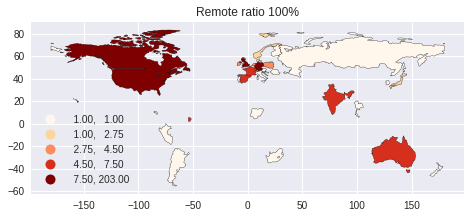

In [56]:
# the world map 2020
# fig, ax = plt.subplots(1, 1, figsize=(15, 15))
fig, ax = plt.subplots(1, 1)
remote_ratio_hund = geo.GeoDataFrame(dataset_remote_geo[dataset_remote_geo.remote_ratio == 100])
missing_kwds = dict(color='grey', label='No Data')
remote_ratio_hund.plot(
    column="counter",
    ax=ax,
    legend=True,
    legend_kwds={'loc': 'lower left'},
    vmin=0.,
    cmap='OrRd', 
    k=8,
    scheme='quantiles',
    edgecolor='black',   
    
)
# ax.tick_params(axis='both', labelsize=15)
# ax.set_title('Remote ratio 2020',fontsize=30)
plt.rc('legend', fontsize=5)

ax.set_title('Remote ratio 100%')
plt.tight_layout()
plt.savefig('100_remote_ratio_world_map_2020.png')
plt.show()

We also plot the map for remote ratio 50% and 0%, but we lack lots of data , so we focus on remote ratio 100%

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/usr/local/lib/python3.7/dist-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


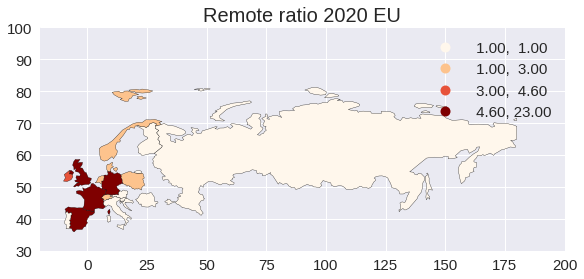

In [77]:
fig, ax = plt.subplots(1, 1)
geo_2020_eu = geo.GeoDataFrame(dataset_remote_geo[dataset_remote_geo.remote_ratio == 100][dataset_remote_geo.continent == "Europe"])
geo_2020_eu.plot(
    column="counter",
    ax=ax,
    legend=True,
    legend_kwds={'loc': 'upper right'},
    vmin=0.,
    cmap='OrRd', 
    k=5,
    scheme='quantiles',
    edgecolor='black',   
)
minx, miny, maxx, maxy = -20, 30, 200,100 
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.tick_params(axis='both', labelsize=15)
ax.set_title('Remote ratio 2020 EU',fontsize=20)
plt.rc('legend', fontsize=15)
plt.savefig('remote_ratio_world_map_2020_eu.png')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


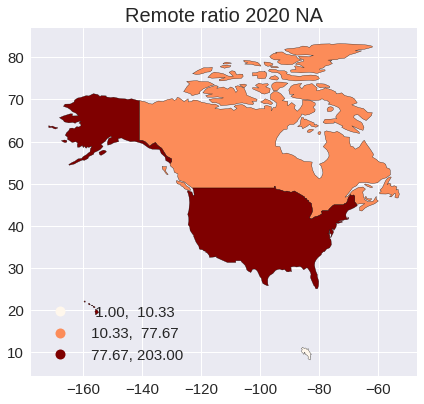

In [76]:
fig, ax = plt.subplots(1, 1)
geo_2020_na = geo.GeoDataFrame(dataset_remote_geo[dataset_remote_geo.remote_ratio == 100][dataset_remote_geo.continent == "North America"])
geo_2020_na.plot(
    column="counter",
    ax=ax,
    legend=True,
    legend_kwds={'loc': 'lower left'},
    vmin=0.,
    cmap='OrRd', 
    k=3,
    scheme='quantiles',
    edgecolor='black',   
)

ax.set_title('Remote ratio 2020 NA',fontsize =20)
plt.rc('legend', fontsize=15)
ax.tick_params(axis='both', labelsize=15)
plt.savefig('remote_ratio_world_map_2020_na.png')
plt.show()

In [78]:
# geo_2020_na

In [79]:
# geo_2020_eu